In [1]:
import sys
import os
current_dir = os.path.abspath('')  # 获取当前目录的绝对路径
parent_dir = os.path.dirname(current_dir)  # 获取父目录
sys.path.append(parent_dir + '\\scripts')

print("Current directory:", current_dir)
print("Parent directory:", parent_dir)

%load_ext autoreload
%aimport source, vis, pinn, dde_param, dataset
%autoreload 1
%aimport

import source, vis, pinn, dde_param

Current directory: d:\Git\PINN-LiDAR\sample
Parent directory: d:\Git\PINN-LiDAR


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Modules to reload:
dataset dde_param pinn source vis

Modules to skip:



In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np

from source import create_source
from vis import Avis
from dde_param import AcousticDeepONet

x_l = 0
x_u = 1

t_l = 0
t_u = np.pi/2

space = dde.geometry.Interval(0, 1)
time = dde.geometry.TimeDomain(0, 5)
geomtime = dde.geometry.GeometryXTime(space, time)

# 1) 创建并初始化
sim = AcousticDeepONet(n_sensors=ns)
sim.setup_source('spherical', freq=300, radius=0.15)

import torch
dim_x = 5
sin = torch.sin
cos = torch.cos
concat = torch.cat

# PDE
def pde(x, y, v):
    dy_x = dde.grad.jacobian(y, x, j=0)
    dy_t = dde.grad.jacobian(y, x, j=1)
    return dy_t + dy_x


def pde(x, y, v):
    "freq: list of frequency"
    freq = 1000
    obs = x
    print(f"Type of loc: {type(obs)}")  # 添加这一行调试类型

    sim.source.update_params(freq = freq, obs = obs)
    pressure = sim.source.compute_pressure(obs=obs)
    
    return pressure

def pde(x, y, v):
    """
    定义二维Helmholtz方程的PDE残差。
    
    x: 输入坐标，包括(x, y)或(x, y, t)等空间/时空变元
    y: 网络输出预测值
    """
    
    u_xx = dde.grad.hessian(y, x, i=0, j=0)  # 对x的二阶偏导
    u_yy = dde.grad.hessian(y, x, i=1, j=1)  # 对y的二阶偏导
    
    # 波数 k 的定义（可根据实际情况调整）
    k = torch.tensor(1.0)
    
    # Helmholtz方程: Δu + k^2 u = 0
    pde_residual = u_xx + u_yy + k**2 * y -v

    return pde_residual

def compute_v(xt):
    """
    xt: 形状为 (N, 2) 的时空坐标，列顺序为 [空间坐标, 时间]
    返回形状为 (N,) 的源项数组
    """
    x = xt[:, 0]  # 第一列为空间坐标
    t = xt[:, 1]  # 第二列为时间
    
    # 示例：随时间移动的点源（含高斯分布）
    amplitude = np.sin(2 * np.pi * t)  # 1Hz 正弦振荡
    
    # 使用高斯分布表示点源
    sigma = 0.05
    v = amplitude * np.exp(-((x_coord - x0)**2) / (2 * sigma**2))
    return v

# TimePDE会自动处理时空坐标传递
pde_data = dde.data.TimePDE(
    geomtime,
    pde,  # PDE函数需接受时空输入
    [bc, ic],
    num_domain=200,
    auxiliary_var_function=lambda xt: compute_v(xt)
)

# The same problem as advection_aligned_pideeponet.py
# But consider time as the 2nd space coordinate
# to demonstrate the implementation of 2D problems
geom = dde.geometry.Rectangle([0, 0], [1, 1])

def func_ic(x, v):
    return v

def boundary(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)


ic = dde.icbc.DirichletBC(geom, func_ic, boundary)

pde = dde.data.PDE(geom, pde, ic, num_domain=200, num_boundary=200)

# Function space
func_space = dde.data.GRF(kernel="ExpSineSquared", length_scale=1)

# Data
eval_pts = np.linspace(0, 1, num=50)[:, None]
data = dde.data.PDEOperatorCartesianProd(
    pde, func_space, eval_pts, 1000, function_variables=[0], num_test=100, batch_size=32
)

# Net
net = dde.nn.DeepONetCartesianProd(
    [50, 128, 128, 128],
    [dim_x, 128, 128, 128],
    "tanh",
    "Glorot normal",
)


def periodic(x):
    x, t = x[:, :1], x[:, 1:]
    x = x * 2 * np.pi
    return concat([cos(x), sin(x), cos(2 * x), sin(2 * x), t], 1)


net.apply_feature_transform(periodic)

model = dde.Model(data, net)
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(iterations=30000)
dde.utils.plot_loss_history(losshistory)

x = np.linspace(0, 1, num=100)
t = np.linspace(0, 1, num=100)
u_true = np.sin(2 * np.pi * (x - t[:, None]))
plt.figure()
plt.imshow(u_true)
plt.colorbar()

v_branch = np.sin(2 * np.pi * eval_pts).T
xv, tv = np.meshgrid(x, t)
x_trunk = np.vstack((np.ravel(xv), np.ravel(tv))).T
u_pred = model.predict((v_branch, x_trunk))
u_pred = u_pred.reshape((100, 100))
plt.figure()
plt.imshow(u_pred)
plt.colorbar()
plt.show()
print(dde.metrics.l2_relative_error(u_true, u_pred))

KeyboardInterrupt: 

In [2]:
import torch

# 检查是否有可用的GPU
gpu_available = torch.cuda.is_available()
print("GPU Available:", gpu_available)

# 如果有可用的GPU，打印其名字
if gpu_available:
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}:", torch.cuda.get_device_name(i))

GPU Available: True
Device 0: NVIDIA GeForce RTX 4060 Laptop GPU


In [ ]:
import deepxde as dde
import numpy as np

# Define a source term as a geometry input
class SourceGeometry:
    def __init__(self, source_func):
        self.source_func = source_func

    def inside(self, x):
        # Define a condition to check if x is inside the intended domain
        return True

    def on_boundary(self, x):
        # Generally not applicable for source terms
        return False

# Example source function
def source_func(x):
    t = x[:, 0:1]  # Extract time component
    A = 1.0  # This can be a variable parameter
    return A * np.sin(t)

# Define the PDE with source term
def pde(x, y):
    dy_dt = dde.grad.jacobian(y, x, i=0, j=0)
    source = source_func(x)
    return dy_dt - source

def source(x):
    # define where is the neutral location of the source
    return
def geom_deform(x, t):
    # if on the boundary point. the deformation shall be the normal direction of the surface.
    if np.any(np.isclose(x, source)):
        return x + sin(t)
    else:
        return x

# Define a new geometry class that includes source handling
class GeometryXTimeXSource(dde.geometry.GeometryXTime):
    def __init__(self, geom, timedomain, source_geom):
        super().__init__(geom, timedomain)
        self.source_geom = source_geom

    def inside(self, x):
        return super().inside(x)

    def sample_source_points(self, n):
        # Sample n points in the source geometry
        # You may want to implement a specific sampling technique here
        return np.random.rand(n, 1)  # Placeholder implementation

# Create your main and source geometries
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
source_geom = SourceGeometry(source_func)

# Define geometry time and source combined term
gts = GeometryXTimeXSource(geom, timedomain, source_geom)

# Define initial and boundary conditions
ic = dde.IC(gts, lambda x: 0, lambda _, on_initial: on_initial)

# Setup the model
data = dde.data.TimePDE(
    gts,
    pde,
    [ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
)

# Define the neural network with separate trunk and branch
net = dde.maps.DeepONet(
    [1, 128],  # branch net size for space-time input
    [1, 128],  # trunk net size for source input
    "relu",  # common activation function
    "Glorot uniform"  # initializer
)

# Train the model
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=10000)

Compiling model...
'compile' took 0.000593 s



Training model...



RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 1x128)

你提出的想法涉及将时间因素引入空间坐标，从而改变传统的Helmholtz方程以更好地适应动态声源。这是一种通过动态几何变换去理解问题的新思路。我们可以根据你的描述，尝试将 ( x = A \sin(t) ) 代入声学的Helmholtz方程，进行推导和简化。

给定的方程是：
$$
[ s = \nabla^2 p + k^2 p ]
$$
其中，( s ) 是声源，( \nabla^2 ) 是拉普拉斯算子，( k ) 是波数，( p ) 是声压。

引入时间变形的坐标：
$$
[ x = A \sin(t) ]
$$
根据你的想法，我们将此坐标代入方程。对于动态坐标，拉普拉斯算子变为需要涉及时间导数的形式。首先，我们考虑如何计算对 ( x ) 的偏导数变化：

由于 ( x = A \sin(t) )，我们有：
$$
[ \frac{\partial x}{\partial t} = A \cos(t) ]
$$
当使用这个新的坐标，我们需要计算时间和空间的偏导数相结合，公式会变为：
$$
[ \Delta p = \frac{\partial^2 p}{\partial x^2} ]
$$
基于变换的链式法则，我们可以引入关于 ( t ) 的导数。

由于声源 ( s ) 只在 ( x = x_0 ) 时存在，其他情况下 ( s = 0 )，我们需要重新定义这个条件，加入时间变化。可以使用一个delta函数或者一个相似函数表示这一性质。

用一个sigma函数代表的声源可以表述为：
$$
[ s(t, x) = \sigma(x - A \sin(t)) ]
$$
在新的坐标下，改革方程后将表达为：
$$
[ \sigma(x - A \sin(t)) = \nabla_t^2 p + k^2 p ]
$$
其中 (\nabla_t^2) 是考虑时间变形的拉普拉斯算子，可以依赖于具体的空间和时间关系进行具体化。

首先，变形信息被包含在 ( D ) 中，其定义为：

$[ \sigma(x, t) = \begin{cases} A, & x = x_0 - \sin(t) \ 0, & \text{其他情况下} \end{cases} ]$

变形矩阵
$[ D(x, t) = \sigma(x, t) ]$

空间变形的引入
将变形矩阵 ( D ) 引入到位置坐标中： $[ x_{\text{new}} = x + D(x, t) ]$

这会影响原始方程中的空间导数，因此我们需要重新计算声场的分布。

新的方程框架
假设我们从声波方程开始进行描述，再加入变形。由以下步骤进行：

声学波动方程： $[ \frac{1}{c^2} \frac{\partial^2 p}{\partial t^2} - \nabla^2 p = \text{Source} ]$

引入动态坐标变化： 根据变形 ( x_{\text{new}} = x + D(x, t) )，我们将导数重新表示： $[ \frac{\partial}{\partial x} \to \frac{\partial}{\partial x} + \frac{\partial D}{\partial x} ]$ $[ \nabla^2 p \to \left( \nabla + \nabla D \right)^2 p ]$

简处理论： 插入新的梯度表达式入波动方程以考虑这种动态修改： $[ \frac{1}{c^2} \frac{\partial^2 p}{\partial t^2} - \left( \nabla + \nabla D \right)^2 p = A \delta(x - x_0 + \sin(t)) ]$

In [4]:
# Requirement: tensorflow or pytorch backend
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# 新的PDE方程，包括时间和空间变形
def pde(xyt, p, v):
    c = 1  # wave speed
    A = 1  # amplitude of source
    x, t = xyt[:, 0:1], xyt[:, 2:3]

    # Second time derivative
    dp_tt = dde.grad.hessian(p, xyt, component=0, i=2, j=2)
    # Gradient and Laplacian with deformation
    grad_dp = dde.grad.jacobian(p, xyt, i=0, j=0)
    laplace_p = dde.grad.hessian(p, xyt, component=0, i=0, j=0)
    deformed_laplace_p = laplace_p + grad_dp * np.cos(t)  # Example deformation

    # Modified Helmholtz equation with source
    source = v
    return dp_tt - c**2 * deformed_laplace_p - source

# Geometry and temporal domain
geom = dde.geometry.Rectangle([0, 0], [1, 1])
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial and Boundary conditions
ic = dde.icbc.IC(geomtime, lambda x: 0, lambda _, on_initial: on_initial)
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)

# PDE problem setup
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=5000,
    num_boundary=1000,
    num_initial=1000,
)

# Neural network setup
net = dde.nn.FNN([3] + [50] * 3 + [1], "tanh", "Glorot normal")

# Model definition
model = dde.Model(data, net)
model.compile("adam", lr=0.001)

# Training
losshistory, train_state = model.train(epochs=10000)

# Plotting results
dde.utils.plot_loss_history(losshistory)
plt.show()

Compiling model...
'compile' took 0.000386 s

Training model...



ValueError: Auxiliary variable function not defined.

原始的波动方程: $[ \nabla^2 p = \frac{1}{c^2} \frac{\partial^2 p}{\partial t^2} ]$

我们希望将 (x_{\text{new}} = x + D) 代入此方程。

步骤
空间导数的变换: $[ \nabla_{\text{new}} = \nabla (x + D) = \nabla x + \nabla D ]$ 由于 (D) 仅影响特定条件下的 (x)，我们考虑到 (D) 对导数的描述是局部性的。

时间导数的变换: 时间导数保持不变，因为形变矩阵 (D) 是基于空间位置的变换，而非时间。

替换并重写方程: $[ \nabla_{\text{new}}^2 p = \nabla^2 (x + D) p = \nabla^2 p + 2 \nabla(\nabla D \cdot p) + (\nabla^2 D) p = \frac{1}{c^2} \frac{\partial^2 p}{\partial t^2} ]$

提取形变 (D): 将 (D) 提取为独立项，使得对 (x) 的描述恢复: $[ \nabla^2 p = \frac{1}{c^2} \frac{\partial^2 p}{\partial t^2} - 2 \nabla(\nabla D \cdot p) - (\nabla^2 D) p ]$

In [ ]:
import deepxde as dde
import numpy as np
import torch

# Constants
c = 1.0  # Define wave speed for context or replace with actual problem-specific value

# Geometry and Time
space = dde.geometry.Rectangle([0, 0], [1, 1])
time = dde.geometry.TimeDomain(0, 1)
geom_time = dde.geometry.GeometryXTime(space, time)

# Deformation matrix function
def deformation_matrix(x, _, t):
    return torch.sin(t - x[:, 0:1].unsqueeze(dim=-1)) * (x[:, 0:1] == 0.5)

# Modified Helmholtz equation function
def modified_helmholtz(x, y):
    """Implements the modified Helmholtz equation with deformation D."""

    c = 343
    dy_tt = dde.grad.hessian(y, x, component=0, i=2, j=2)

    # Compute spatial Laplacian as the sum of second derivatives
    laplacian_y = sum(dde.grad.hessian(y, x, component=0, i=i, j=i) for i in range(2))

    D = deformation_matrix(x, y, x[:, 2:3])
    gradient_D = dde.grad.jacobian(D, x, i=0, j=0)
    laplacian_D = sum(dde.grad.hessian(D, x, component=0, i=i, j=i) for i in range(2))

    term1 = laplacian_y
    term2 = -gradient_D * dde.grad.jacobian(y, x, i=0, j=0)
    term3 = -laplacian_D * y

    return term1 - (1 / c**2) * dy_tt + term2 + term3

# Boundary condition function
def boundary(_, on_boundary):
    return on_boundary

bc = dde.icbc.DirichletBC(geom_time, lambda _: 0, boundary)

# Initial condition function
def initial_condition(x):
    return np.ones((x.shape[0], 1))  # Ensure return shape is (N, 1)

def on_initial(x, _):
    return np.isclose(x[-1], 0)  # Assume time dimension is the last index

ic = dde.icbc.IC(geom_time, initial_condition, on_initial)

# Define the PDE problem data
data = dde.data.TimePDE(
    geom_time,
    modified_helmholtz,
    [bc, ic],
    num_domain=1000,
    num_boundary=200
)

# Neural network definition
net = dde.nn.FNN([3] + [50] * 3 + [1], "tanh", "Glorot normal")

# Train the model
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=5000)

# Fix prediction dimensions before plotting
if hasattr(train_state, 'best_y'):
    train_state.best_y = train_state.best_y.reshape(-1, 1)  # Ensure (N,1) shape

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 0.001282 s

Training model...



TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [9]:
"""Backend supported: tensorflow.compat.v1, pytorch, paddle"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np

# PDE

# Deformation matrix function
def deformation_matrix(x, _, t):
    return torch.sin(t - x[:, 0:1].unsqueeze(dim=-1)) * (x[:, 0:1] == 0.5)

# Modified Helmholtz equation function
def pde(x, y, v):
    """Implements the modified Helmholtz equation with deformation D."""
    c = 343

    # print(x.shape, y.shape)  # 在pde函数开头添加
    # Change i=2 to i=1 for time derivative (assuming x[:,1] is time)
    dy_tt = dde.grad.hessian(y, x, component=0, i=1, j=1)  

    # Compute spatial Laplacian as the sum of second derivatives
    laplacian_y = sum(dde.grad.hessian(y, x, component=0, i=i, j=i) for i in range(1))  # Only spatial dimension
    
    D = deformation_matrix(x, y, x[:, 1:2])  # Assuming time is second column
    gradient_D = dde.grad.jacobian(D, x, i=0, j=0)
    laplacian_D = sum(dde.grad.hessian(D, x, component=0, i=i, j=i) for i in range(1))  # Only spatial dimension
    
    term1 = laplacian_y
    term2 = -gradient_D * dde.grad.jacobian(y, x, i=0, j=0)
    term3 = -laplacian_D * y
    return term1 - (1 / c**2) * dy_tt + term2 + term3


geom = dde.geometry.Interval(0, 0.01)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda _: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda _: 0, lambda _, on_initial: on_initial)

pde = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=100,    # 训练集域内点
    num_boundary=20,   # 训练集边界点
    num_initial=10,    # 训练集初始条件点
    num_test=100,
    solution=None,
    train_distribution="pseudo",  # 禁用自适应采样
)

# Function space
func_space = dde.data.GRF(length_scale=0.2)

# Data
eval_pts = np.linspace(0, 0.01, num=30)[:, None]
data = dde.data.PDEOperator(
    pde, func_space, eval_pts, 100, function_variables=[0], num_test=100
)

# Net
net = dde.nn.DeepONet(
    [30, 128, 128, 128],
    [2, 128, 128, 128],
    "tanh",
    "Glorot normal",
)


In [3]:
"""Backend supported: tensorflow.compat.v1, pytorch, paddle"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import torch

# PDE
# Deformation matrix function with parameter w
def deformation_matrix(x, _, t, w):
    return torch.sin(w * t - x[:, 0:1].unsqueeze(dim=-1)) * (x[:, 0:1] == 0.5)

# Modified Helmholtz equation function
def helmholtzpde(x, y, v, aux):
    """ Implements the modified Helmholtz equation with deformation D. """
    c = 343
    w = aux[0]  # Access auxiliary variable w

    # directly modify x to the new_x

    # here, deformation matrix shall return the matrix same size as x, with actural x and t in second column.

    # then, the helmholtz equation can be directly computed as normal, without additional term

    # to avoid the overlap of the actural x, we add exponential decaying A to the x near to the sin(t)

    # however, this can be simplified, say, use the 1 directly. or a simple winow function. 

    # the deformation matrix actually act like positional encoding.
    D = deformation_matrix(x, y, x[:, 1:2], w)
    x = x + D
    dy_tt = dde.grad.hessian(y, x, component=0, i=1, j=1)
    laplacian_y = sum(dde.grad.hessian(y, x, component=0, i=i, j=i) for i in range(1))
    gradient_D = dde.grad.jacobian(D, x, i=0, j=0)
    laplacian_D = sum(dde.grad.hessian(D, x, component=0, i=i, j=i) for i in range(1))
    term1 = laplacian_y
    
    term2 = -gradient_D * dde.grad.jacobian(y, x, i=0, j=0)
    
    term3 = -laplacian_D * y
    return term1 - (1 / c**2) * dy_tt + term2 + term3

geom = dde.geometry.Interval(0, 0.01)
timedomain = dde.geometry.TimeDomain(0, 0.01)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda _: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda _: 0, lambda _, on_initial: on_initial)

# Provide w as an auxiliary variable
w = np.linspace(1000, 10000, num=10)  # Example value for w

pde = dde.data.TimePDE(
    geomtime,
    lambda x, y, v: helmholtzpde(x, y, v, aux=w),
    [bc, ic],
    num_domain=100,    # 训练集域内点
    num_boundary=20,   # 训练集边界点
    num_initial=10,    # 训练集初始条件点
    num_test=100,
    solution=None,
    train_distribution="pseudo",  # 禁用自适应采样
)

# Function space
func_space = dde.data.GRF(length_scale=0.2)

# Data
eval_pts = np.linspace(0, 0.01, num=24)[:, None]
data = dde.data.PDEOperator(
    pde, func_space, eval_pts, 1000, function_variables=[0], num_test=100
)

# Net
net = dde.nn.DeepONet(
    [24, 128, 128, 128],
    [2, 128, 128, 128],
    "tanh",
    "Glorot normal",
)

In [10]:

model = dde.Model(data, net)
model.compile("adam", lr=0.0005)


Compiling model...
'compile' took 0.000384 s



Training model...

5         [1.13e-03, 4.31e-02, 7.52e-05]    [1.19e-03, 4.31e-02, 7.52e-05]    []  
100       [1.23e-07, 1.72e-06, 4.58e-07]    [1.53e-07, 1.72e-06, 4.58e-07]    []  
200       [7.83e-08, 6.98e-07, 3.17e-07]    [1.32e-07, 6.98e-07, 3.17e-07]    []  
300       [6.81e-08, 5.00e-07, 2.06e-07]    [1.26e-07, 5.00e-07, 2.06e-07]    []  
400       [6.48e-08, 3.53e-07, 1.25e-07]    [1.22e-07, 3.53e-07, 1.25e-07]    []  
500       [6.21e-08, 2.55e-07, 7.27e-08]    [1.16e-07, 2.55e-07, 7.27e-08]    []  
600       [5.86e-08, 1.95e-07, 4.25e-08]    [1.08e-07, 1.95e-07, 4.25e-08]    []  
700       [5.43e-08, 1.58e-07, 2.61e-08]    [9.89e-08, 1.58e-07, 2.61e-08]    []  
800       [4.96e-08, 1.33e-07, 1.75e-08]    [9.02e-08, 1.33e-07, 1.75e-08]    []  
900       [4.48e-08, 1.16e-07, 1.30e-08]    [8.20e-08, 1.16e-07, 1.30e-08]    []  
1000      [4.01e-08, 1.03e-07, 1.05e-08]    [7.45e-08, 1.03e-07, 1.05e-08]    []  
1100      [3.58e-08, 9.15e-08, 9.05e-09]    [6.79e-08, 9.15e-08, 9.0

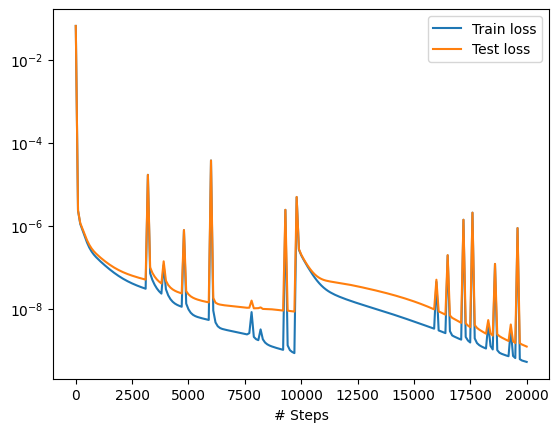

In [12]:

losshistory, train_state = model.train(iterations=20000, batch_size=32, display_every=100)
dde.utils.plot_loss_history(losshistory)


In [48]:

save_dir = "my_model"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, "question.ckpt")

model.save(model, model_path)

'<deepxde.model.Model object at 0x0000024A3C3B6420>-0'

In [59]:
model = dde.Model(data, net)

model_weights = torch.load("my_model/question.ckpt-20005.pt", weights_only=False)

model.restore("my_model/question.ckpt-20005.pt", verbose=1)


Restoring model from my_model/question.ckpt-20005.pt ...



C:\Users\1ieng\AppData\Roaming\Python\Python312\site-packages\deepxde\model.py:1130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path)


AttributeError: 'NoneType' object has no attribute 'load_state_dict'

In [ ]:

func_feats = func_space.random(20)
xs = np.linspace(0, 1, num=100)[:, None]
v = func_space.eval_batch(func_feats, xs)[0]

v_branch = func_space.eval_batch(func_feats, np.linspace(0, 1, num=30)[:, None])[0]

x = np.linspace(0, 100, num=1000)  # 匹配geom区间[0,0.01]
t = np.linspace(0, 1000, num=1000)     # 匹配timedomain[0,1]

xv, tv = np.meshgrid(x, t)
x_trunk = np.vstack((np.ravel(xv), np.ravel(tv))).T
u_pred = model.predict((np.tile(v_branch, (1000 * 1000, 1)), x_trunk))
u_pred = u_pred.reshape((1000, 1000))

plt.figure()
plt.plot(u_pred[:, 0], label = "t = 0s")
plt.title("prediction on distance")
plt.xlabel("distance")
plt.ylabel("amplitude")

plt.plot(u_pred[:, 999], label = "t = 1000s")
plt.title("prediction on distance")
plt.xticks(np.arange(0, 1000, 50), labels=np.arange(0, 100, 5))
plt.ylabel("amplitude")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.imshow(u_pred)
plt.show()

AttributeError: 'dict' object has no attribute 'eval'

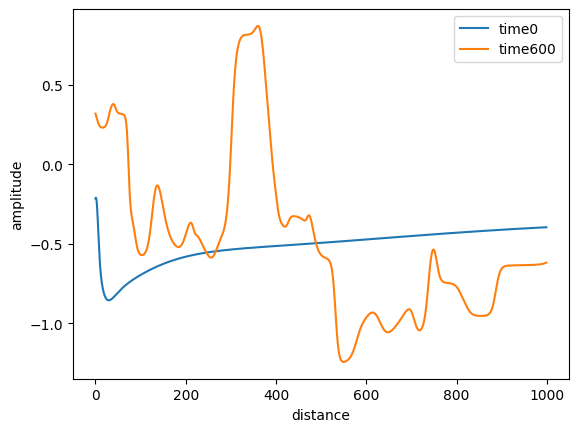

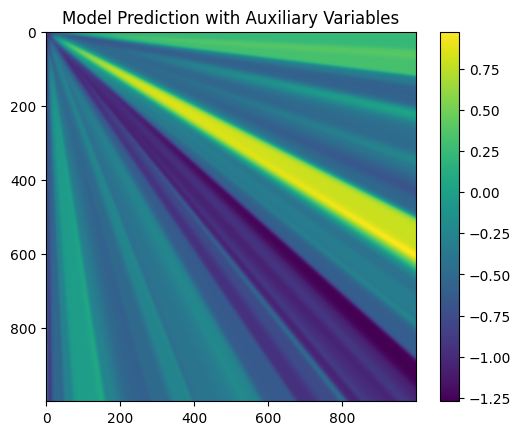

In [43]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Define the custom operator
def custom_operator(inputs, outputs, auxiliary_vars):
    """Operator to process auxiliary variables with predictions."""
    w = auxiliary_vars.to(outputs.device)  # Ensure w is on the same device
    return outputs * w

# Auxiliary variable as a tensor (on the desired device)
w_aux = torch.tensor([1], device='cuda')
# Example prediction setup

x = np.linspace(0, 1000, num=1000)  # 匹配geom区间[0,0.01]
t = np.linspace(0, 1000, num=1000)     # 匹配timedomain[0,1]

xv, tv = np.meshgrid(x, t)
x_trunk = np.vstack((np.ravel(xv), np.ravel(tv))).T

# Prepare the branch input if necessary
v_branch = func_space.eval_batch(func_feats, np.linspace(0, 1, num=30)[:, None])[0]
inputs = (np.tile(v_branch, (1000 * 1000, 1)), x_trunk)

# Repeat auxiliary data as a tensor
w_repeated = w_aux.repeat(1000 * 1000, 1)

# Perform prediction with operator
u_pred = model.predict(inputs, operator=lambda inp, out: custom_operator(inp, out, w_repeated))
u_pred = u_pred.reshape((1000, 1000))

plt.figure()
plt.plot(u_pred[:, 1], label = "time0")
plt.plot(u_pred[:, 600], label = "time600")
plt.xlabel("distance")
plt.ylabel("amplitude")
plt.legend()
plt.show()

# Plot results
plt.figure()
plt.imshow(u_pred)
plt.colorbar()
plt.title("Model Prediction with Auxiliary Variables")
plt.show()

Analysis to above plot: Dispersion relationship? + the wave travelling

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
num_elements = 100
length = 1000
c = 343      # 声速
dx = length / num_elements
dt = 1
num_time_steps = 1000

# 初始化
num_nodes = num_elements + 1
x = np.linspace(0, length, num_nodes)
P = np.zeros((num_time_steps, num_nodes))

# 创建全局矩阵
K_global = np.zeros((num_nodes, num_nodes))
M_global = np.zeros((num_nodes, num_nodes))

# 刚度与质量矩阵的组装
for i in range(num_elements):
    K_local = np.array([[1, -1], [-1, 1]]) / dx
    M_local = np.array([[2, 1], [1, 2]]) * dx / 6
    indices = [i, i + 1]
    for a in range(2):
        for b in range(2):
            K_global[indices[a], indices[b]] += K_local[a, b]
            M_global[indices[a], indices[b]] += M_local[a, b]

# 初始条件
p = np.zeros(num_nodes)
p_new = np.zeros(num_nodes)
p_old = np.zeros(num_nodes)

# 时间步进（中心差分法）
for n in range(1, num_time_steps):
    # 在 x=0 处施加边界条件
    p[0] = np.sin(1*i * n * dt)

    # 更新方程: M * p_new = (M - dt^2 * K) * p + M * p_old
    rhs = np.dot(M_global, 2 * p - p_old) - dt**2 * np.dot(K_global, p)
    p_new = np.linalg.solve(M_global, rhs)

    # 更新历史
    p_old = p.copy()
    p = p_new.copy()

    # 存储结果
    P[n] = p


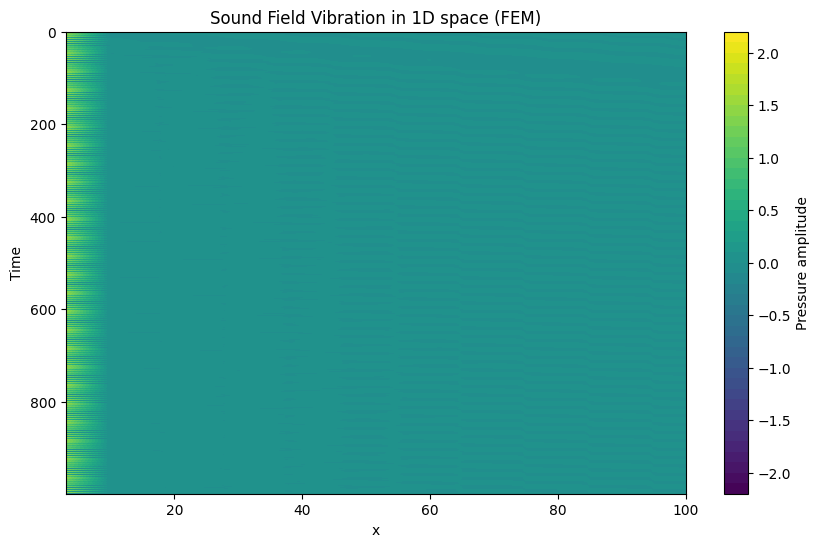

In [41]:

# 绘制声场随时间和空间变化的图像
T, X = np.meshgrid(np.arange(num_time_steps) * dt, x)

plt.figure(figsize=(10, 6))
plt.contourf(X, T, np.real(P.T), levels=50, cmap='viridis')
plt.gca().invert_yaxis()
plt.xlim(3, 100)
plt.colorbar(label='Pressure amplitude')
plt.xlabel('x')
plt.ylabel('Time')
plt.title('Sound Field Vibration in 1D space (FEM)')
plt.show()

(-0.1, 0.2)

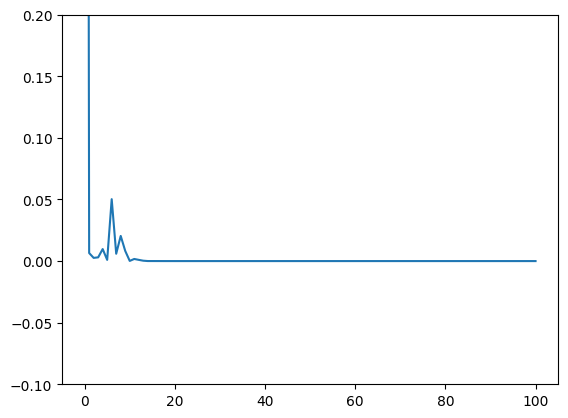

In [39]:
plt.plot(np.abs(P[50, :]))
plt.ylim(-0.1, 0.2)